In [1]:
import pandas as pd

In [ ]:

df = pd.read_csv("../data/raw/kidney_disease_dataset.csv")

print("Shape:", df.shape)


Shape: (2304, 9)


### Data Loading and Initial Inspection

In this section, we load the dataset and perform an initial inspection to understand
its structure, feature types, and potential data quality issues such as missing values.

Dataset size: 2,304 rows × 9 columns.

Next, we will (1) define the prediction target, (2) examine class balance, and (3) explore feature distributions and relationships.


In [3]:
df.head()


,Age,Creatinine_Level,BUN,Diabetes,Hypertension,GFR,Urine_Output,CKD_Status,Dialysis_Needed
0,71,0.30,40.9,0,1,46.8,1622.0,1,0
1,34,1.79,17.1,0,0,43.8,1428.0,1,0
2,80,2.67,15.0,0,1,78.2,1015.0,1,0
3,40,0.97,31.1,0,1,92.8,1276.0,1,0
4,43,2.05,22.8,1,1,62.2,1154.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               2304 non-null   int64  
 1   Creatinine_Level  2304 non-null   float64
 2   BUN               2304 non-null   float64
 3   Diabetes          2304 non-null   int64  
 4   Hypertension      2304 non-null   int64  
 5   GFR               2304 non-null   float64
 6   Urine_Output      2304 non-null   float64
 7   CKD_Status        2304 non-null   int64  
 8   Dialysis_Needed   2304 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 162.1 KB


In [5]:
df.isnull().sum().sort_values(ascending=False)

Age                 0
Creatinine_Level    0
BUN                 0
Diabetes            0
Hypertension        0
GFR                 0
Urine_Output        0
CKD_Status          0
Dialysis_Needed     0
dtype: int64

## 2. Define Target and Check Class Balance

We choose **CKD_Status** as the primary prediction target. Before modeling, we check class balance because imbalance affects model choice and evaluation metrics.


In [6]:
df.columns

Index(['Age', 'Creatinine_Level', 'BUN', 'Diabetes', 'Hypertension', 'GFR',
       'Urine_Output', 'CKD_Status', 'Dialysis_Needed'],
      dtype='object')

In [7]:
target_col = "CKD_Status"
df[target_col].value_counts(dropna=False)

CKD_Status
1    1172
0    1132
Name: count, dtype: int64

In [8]:
df[target_col].value_counts(normalize=True)

CKD_Status
1    0.508681
0    0.491319
Name: proportion, dtype: float64

## 3. Exploratory Data Analysis (EDA)

We explore feature distributions and relationships with the target to understand signal, detect outliers, and guide preprocessing.


Matplotlib is building the font cache; this may take a moment.


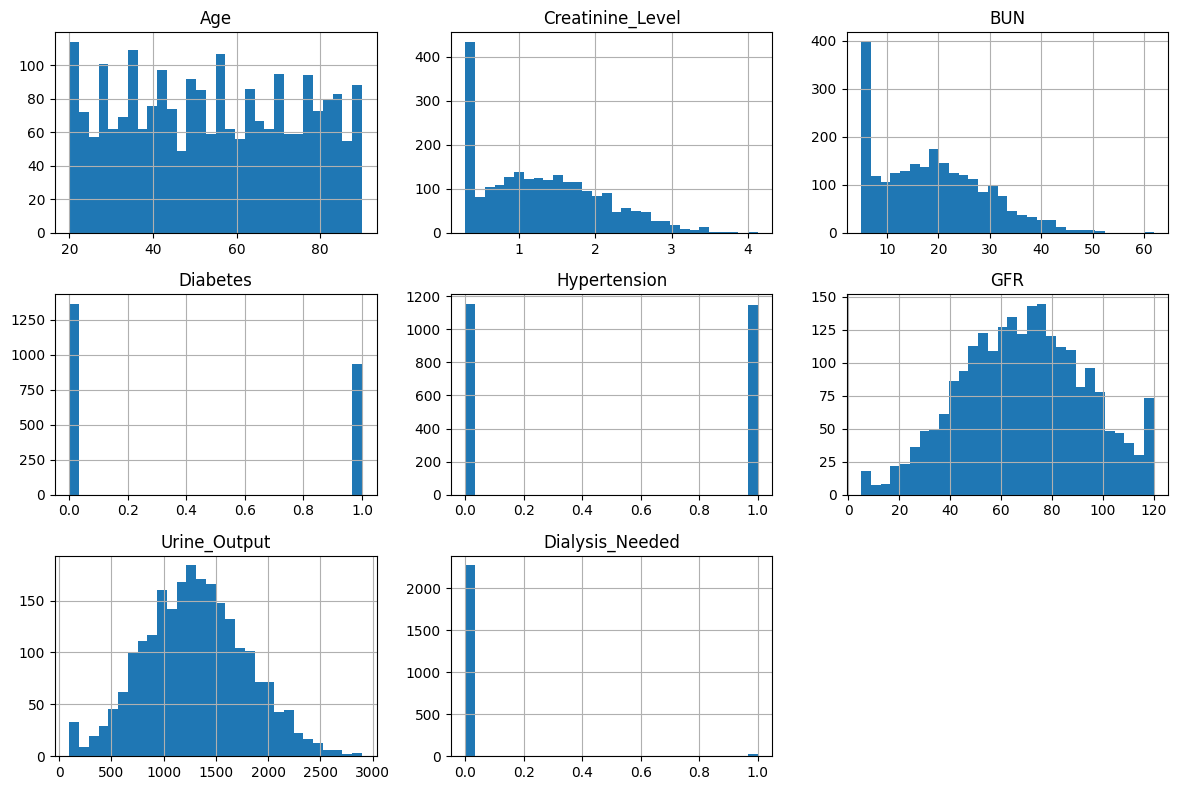

In [9]:
import matplotlib.pyplot as plt

numeric_cols = [c for c in df.columns if c != target_col]

df[numeric_cols].hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()


In [10]:
corr = df[numeric_cols + [target_col]].corr()
corr[target_col].sort_values(ascending=False)


CKD_Status          1.000000
BUN                 0.305803
Creatinine_Level    0.185017
Dialysis_Needed     0.114773
Diabetes            0.018322
Age                 0.012416
Hypertension       -0.027722
Urine_Output       -0.041600
GFR                -0.601672
Name: CKD_Status, dtype: float64